# SECTION 1 — TensorFlow / Keras : MLP for MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## Load MNIST

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Preprocessing

In [3]:
X_train = X_train.reshape(X_train.shape[0], -1).astype("float32") / 255.0
X_test  = X_test.reshape(X_test.shape[0], -1).astype("float32") / 255.0
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

## Model

In [4]:
tf_model = Sequential([
    Dense(256, activation="relu", input_shape=(784,)),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(10, activation="softmax")
])

tf_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Train

In [5]:
history = tf_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7653 - loss: 0.7487 - val_accuracy: 0.9548 - val_loss: 0.1615
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9409 - loss: 0.1984 - val_accuracy: 0.9663 - val_loss: 0.1154
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9566 - loss: 0.1437 - val_accuracy: 0.9708 - val_loss: 0.0990
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9662 - loss: 0.1125 - val_accuracy: 0.9740 - val_loss: 0.0907
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9719 - loss: 0.0941 - val_accuracy: 0.9737 - val_loss: 0.0848
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9741 - loss: 0.0829 - val_accuracy: 0.9761 - val_loss: 0.0829
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9789 - loss: 0.0674 - val_accuracy: 0.9757 - val_loss: 0.0818
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9797 - loss: 0.0634 - val_accuracy: 0.

## Evaluate

In [6]:
tf_loss, tf_acc = tf_model.evaluate(X_test, y_test, verbose=0)
print(f"[TensorFlow] Test Accuracy: {tf_acc:.4f}")

[TensorFlow] Test Accuracy: 0.9798


## Plot

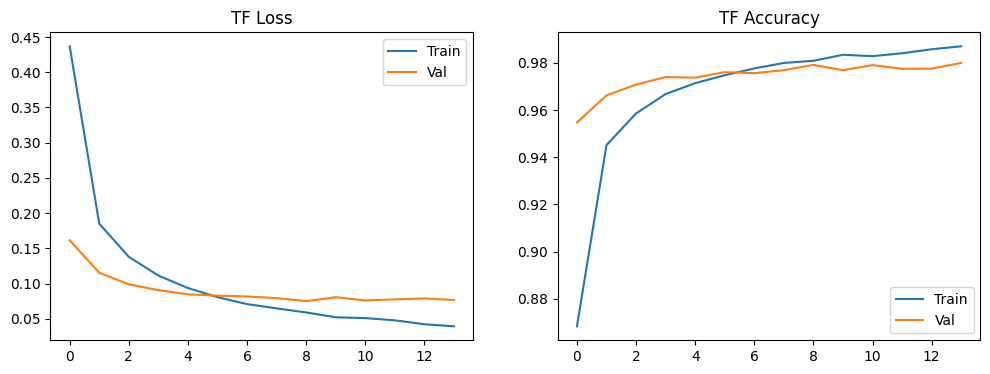

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("TF Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("TF Accuracy")
plt.legend()
plt.show()

# SECTION 2 — PyTorch : MLP for MNIST

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [9]:
batch_size = 20
epochs = 30

## Dataset

In [10]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.10MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.61MB/s]


## Model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        return self.fc3(x)

torch_model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(torch_model.parameters(), lr=0.01)

## Train

In [12]:
torch_model.train()
for epoch in range(epochs):
    loss_sum = 0.0
    for x, y in train_loader:
        optimizer.zero_grad()
        out = torch_model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)

    print(f"[PyTorch] Epoch {epoch+1}, Loss: {loss_sum/len(train_loader.dataset):.4f}")

[PyTorch] Epoch 1, Loss: 0.8501
[PyTorch] Epoch 2, Loss: 0.3249
[PyTorch] Epoch 3, Loss: 0.2512
[PyTorch] Epoch 4, Loss: 0.2042
[PyTorch] Epoch 5, Loss: 0.1711
[PyTorch] Epoch 6, Loss: 0.1479
[PyTorch] Epoch 7, Loss: 0.1303
[PyTorch] Epoch 8, Loss: 0.1161
[PyTorch] Epoch 9, Loss: 0.1034
[PyTorch] Epoch 10, Loss: 0.0949
[PyTorch] Epoch 11, Loss: 0.0862
[PyTorch] Epoch 12, Loss: 0.0793
[PyTorch] Epoch 13, Loss: 0.0732
[PyTorch] Epoch 14, Loss: 0.0689
[PyTorch] Epoch 15, Loss: 0.0630
[PyTorch] Epoch 16, Loss: 0.0587
[PyTorch] Epoch 17, Loss: 0.0555
[PyTorch] Epoch 18, Loss: 0.0528
[PyTorch] Epoch 19, Loss: 0.0493
[PyTorch] Epoch 20, Loss: 0.0458
[PyTorch] Epoch 21, Loss: 0.0430
[PyTorch] Epoch 22, Loss: 0.0421
[PyTorch] Epoch 23, Loss: 0.0388
[PyTorch] Epoch 24, Loss: 0.0363
[PyTorch] Epoch 25, Loss: 0.0350
[PyTorch] Epoch 26, Loss: 0.0341
[PyTorch] Epoch 27, Loss: 0.0317
[PyTorch] Epoch 28, Loss: 0.0307
[PyTorch] Epoch 29, Loss: 0.0283
[PyTorch] Epoch 30, Loss: 0.0266


## Evaluate

In [13]:
torch_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        out = torch_model(x)
        _, pred = torch.max(out, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)

print(f"[PyTorch] Test Accuracy: {100*correct/total:.2f}%")

[PyTorch] Test Accuracy: 98.17%


### **Mount Google Drive**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Save TensorFlow / Keras model**

In [19]:
import os

SAVE_DIR = "/content/drive/MyDrive/praktikum_ml/praktikum13/models"
os.makedirs(SAVE_DIR, exist_ok=True)

tf_model.save(f"{SAVE_DIR}/mnist_mlp_tf.keras")

**Alternatif (.h5, legacy):**

In [16]:
tf_model.save(f"{SAVE_DIR}/mnist_mlp_tf.h5")

### **Save PyTorch model**

In [17]:
import os
import torch

SAVE_DIR = "/content/drive/MyDrive/praktikum_ml/praktikum13/models"
os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(
    torch_model.state_dict(),
    f"{SAVE_DIR}/mnist_mlp_torch.pth"
)

### **Save PyTorch full model**

In [18]:
torch.save(torch_model, f"{SAVE_DIR}/mnist_mlp_torch_full.pt")